In [21]:
#기본 IMPORT
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.autograd import Variable

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE


In [22]:
# 출력 줄수 제한 없애기

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity="all"



X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: t

<Figure size 1000x100 with 0 Axes>

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 8')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 9')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 5')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 0')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 5')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 5')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 7')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 3')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 7')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 9')

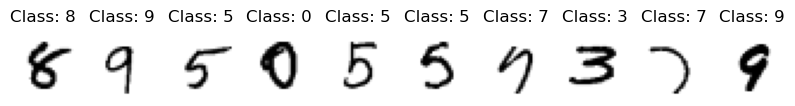

In [23]:
#Device 및 기본 설정 + 데이터셋 받아오기(MNIST)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE=32
EPOCHS=10

train_dataset = datasets.MNIST(root='data/MNIST',train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='data/MNIST',train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE, shuffle=False)

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(),'type:',X_train.type())
    print('y_train:',y_train.size(), 'type:',y_train.type())

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize)) #10개 plot하기 위한 figure 크기 설정

for i in range(10):
    plt.subplot(1, 10, i + 1) # plot.subplot(rows, columns, index)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [24]:
#모델을 4층구조 - Conv - Relu - Pooling 4층
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool(F.gelu(self.bn2(self.conv2(x))))
        
        x = x.view(-1, 64 * 7 * 7)
        
        x = F.gelu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        
        x = F.gelu(self.bn_fc2(self.fc2(x)))
        x = self.dropout(x)
        
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x


In [25]:
#model,optimizer,criterion 설정
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.5)
criterion=nn.CrossEntropyLoss()

print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [26]:
# 학습 함수
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")


In [27]:
# FGSM Attack Function
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

#FGSM(TSNE 시각화용)
def fgsm_attack_2(model, image, label, epsilon, criterion):
    # FGSM attack implementation
    image.requires_grad = True
    output = model(image)
    loss = criterion(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = image + epsilon * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# PGD Attack Function
def pgd_attack(model, image, label, epsilon, alpha, attack_iters, criterion):
    perturbed_image = image.clone().detach().requires_grad_(True).to(DEVICE)
    original_image = image.clone().detach()
    
    for _ in range(attack_iters):
        output = model(perturbed_image)
        loss = criterion(output, label)
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image.grad.data
        
        perturbed_image = perturbed_image + alpha * data_grad.sign()
        perturbation = torch.clamp(perturbed_image - original_image, min=-epsilon, max=epsilon)
        perturbed_image = torch.clamp(original_image + perturbation, 0, 1).detach_().requires_grad_(True)
    
    return perturbed_image

# Adversarial Training with FGSM
def train_with_fgsm(model, device, train_loader, optimizer, criterion, epochs, epsilon):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data.requires_grad = True
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            data_grad = data.grad.data
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
            
            output = model(perturbed_data)
            loss_adv = criterion(output, target)
            loss_adv.backward()
            optimizer.step()
            
            running_loss += loss.item() + loss_adv.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs} with FGSM Attack, Loss: {avg_loss:.4f}")

# Adversarial Training with PGD
def train_with_pgd(model, device, train_loader, optimizer, criterion, epochs, epsilon, alpha, attack_iters):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            perturbed_data = pgd_attack(model, data, target, epsilon, alpha, attack_iters, criterion)
            output = model(perturbed_data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs} with PGD Attack, Loss: {avg_loss:.4f}")




In [28]:
# Basic Evaluation Function
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(prediction.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    f1 = f1_score(all_labels, all_predictions, average='macro')
    cm = confusion_matrix(all_labels, all_predictions)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"F1 Score (Macro): {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)


In [29]:
def visualize_comparison(original_images_list, perturbed_images_list, original_labels_list, perturbed_preds_list, num_images=16):
    """
    Visualizes original and adversarial images side by side.
    
    Parameters:
    - original_images_list: List of tensors containing original images.
    - perturbed_images_list: List of tensors containing adversarial images.
    - original_labels_list: List of original labels.
    - perturbed_preds_list: List of adversarial predictions.
    - num_images: Number of image pairs to visualize.
    """
    # Concatenate all batches into a single tensor and ensure they are detached
    original_images = torch.cat(original_images_list, dim=0)[:num_images].detach()
    perturbed_images = torch.cat(perturbed_images_list, dim=0)[:num_images].detach()
    original_labels = np.concatenate(original_labels_list, axis=0)[:num_images]
    perturbed_preds = np.concatenate(perturbed_preds_list, axis=0)[:num_images]
    
    # Calculate the number of rows needed
    num_cols = 8  # Number of images per row
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows needed to display all images

    fig, axes = plt.subplots(2 * num_rows, num_cols, figsize=(2 * num_cols, 4 * num_rows))
    
    for i in range(num_images):
        row = (i // num_cols) * 2  # Determine the row index (original and adversarial)
        col = i % num_cols  # Determine the column index
        
        # Original Image
        axes[row, col].imshow(original_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[row, col].set_title(f"Original: {original_labels[i]}")
        axes[row, col].axis('off')
        
        # Adversarial Image
        axes[row + 1, col].imshow(perturbed_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[row + 1, col].set_title(f"Adversarial: {perturbed_preds[i]}")
        axes[row + 1, col].axis('off')
    
    # Hide any unused subplots
    for i in range(num_images, num_cols * num_rows):
        row = (i // num_cols) * 2
        col = i % num_cols
        axes[row, col].axis('off')
        axes[row + 1, col].axis('off')

    plt.tight_layout()
    plt.show()


In [30]:
def visualize_tsne(model, test_loader, epsilon, alpha, iterations, visualize=True, num_images=1000, mode='FGSM'):
    model.eval()
    images_list = []
    labels_list = []

    criterion = torch.nn.CrossEntropyLoss()

    for i, (images, labels) in enumerate(test_loader):
        if i * len(images) >= num_images:
            break

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Apply attack based on mode
        if mode == 'FGSM':
            perturbed_images = fgsm_attack_2(model, images, labels, epsilon, criterion)
        elif mode == 'PGD':
            perturbed_images = pgd_attack(model, images, labels, epsilon, alpha, iterations, criterion)
        else:
            raise ValueError("Mode must be either 'FGSM' or 'PGD'")

        # Collect original and perturbed images for TSNE
        with torch.no_grad():
            images_list.append(images)
            labels_list.append(labels)
            images_list.append(perturbed_images)
            labels_list.append(labels)

    # Stack all images and labels
    images_list = torch.cat(images_list, dim=0)
    labels_list = torch.cat(labels_list, dim=0).cpu().numpy()  # Move to CPU and convert to numpy

    # Pass images through the model to get the features
    with torch.no_grad():
        features = model(images_list).view(images_list.size(0), -1)

    # Apply TSNE to reduce to 2 dimensions
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features.cpu().numpy())

    # Plot the TSNE visualization
    if visualize:
        # Colors and markers for each class (0-9)
        colors = cm.get_cmap('tab10', 10)  # Using a colormap with 10 colors
        markers = ['o', 's', 'v', '^', '<', '>', 'P', '*', 'X', 'D']  # Different markers for diversity

        plt.figure(figsize=(12, 10))
        for class_idx in range(10):
            # Plot original images
            class_mask = (labels_list[:len(images_list)//2] == class_idx)
            plt.scatter(tsne_features[:len(images_list)//2, 0][class_mask], 
                        tsne_features[:len(images_list)//2, 1][class_mask], 
                        color=colors(class_idx), marker=markers[class_idx], label=f'Original {class_idx}', alpha=0.5)
            
            # Plot perturbed images
            class_mask = (labels_list[len(images_list)//2:] == class_idx)
            plt.scatter(tsne_features[len(images_list)//2:, 0][class_mask], 
                        tsne_features[len(images_list)//2:, 1][class_mask], 
                        color=colors(class_idx), marker=markers[class_idx], label=f'Perturbed {class_idx}', edgecolor='k', alpha=0.5)
        
        # Set the legend to appear in the top right and split into 2 columns
        plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=2)
        plt.title(f'TSNE Visualization - {mode} Attack')
        plt.show()

    return tsne_features, labels_list


In [31]:
# Evaluation with FGSM Attack
def evaluate_with_fgsm_attack(model, test_loader, criterion, epsilon, visualize=True, num_images=5):
    model.eval()
    clean_loss, adv_loss = 0, 0
    clean_correct, adv_correct = 0, 0
    clean_labels, clean_preds = [], []
    adv_labels, adv_preds = [], []
    
    # For Visualization
    original_images_list = []
    perturbed_images_list = []
    original_labels_list = []
    perturbed_preds_list = []
    
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        # Clean Evaluation
        output = model(data)
        clean_loss += criterion(output, target).item()
        clean_pred = output.max(1, keepdim=True)[1]
        clean_correct += clean_pred.eq(target.view_as(clean_pred)).sum().item()
        
        clean_labels.extend(target.cpu().numpy())
        clean_preds.extend(clean_pred.cpu().numpy())
        
        # FGSM Attack
        data.requires_grad = True
        output = model(data)
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # Adversarial Evaluation
        output = model(perturbed_data)
        adv_loss += criterion(output, target).item()
        adv_pred = output.max(1, keepdim=True)[1]
        adv_correct += adv_pred.eq(target.view_as(adv_pred)).sum().item()
        
        adv_labels.extend(target.cpu().numpy())
        adv_preds.extend(adv_pred.cpu().numpy())
        
        # Save for Visualization
        if visualize and len(original_images_list) < num_images:
            # Detach tensors to prevent them from tracking gradients
            original_images_list.append(data.cpu().detach())
            perturbed_images_list.append(perturbed_data.cpu().detach())
            original_labels_list.append(target.cpu().numpy())
            perturbed_preds_list.append(adv_pred.cpu().numpy())
    
    # Calculate Metrics
    clean_loss /= len(test_loader)
    adv_loss /= len(test_loader)
    clean_accuracy = 100. * clean_correct / len(test_loader.dataset)
    adv_accuracy = 100. * adv_correct / len(test_loader.dataset)
    
    clean_f1 = f1_score(clean_labels, clean_preds, average='macro')
    adv_f1 = f1_score(adv_labels, adv_preds, average='macro')
    
    clean_cm = confusion_matrix(clean_labels, clean_preds)
    adv_cm = confusion_matrix(adv_labels, adv_preds)
    
    print(f"Adversarial Test Loss: {adv_loss:.4f}, Adversarial Accuracy: {adv_accuracy:.2f}%")
    print(f"Adversarial F1 Score (Macro): {adv_f1:.4f}")
    print("Adversarial Confusion Matrix:")
    print(adv_cm)
    print(len(original_images_list))
    return original_images_list,perturbed_images_list,original_labels_list,perturbed_preds_list
    # Visualization
    if visualize and original_images_list and perturbed_images_list:
        visualize_comparison(original_images_list, perturbed_images_list, original_labels_list, perturbed_preds_list, num_images=num_images)

# Evaluation with PGD Attack
def evaluate_with_pgd_attack(model, test_loader, criterion, epsilon, alpha, attack_iters, visualize=True, num_images=5):
    model.eval()
    clean_loss, adv_loss = 0, 0
    clean_correct, adv_correct = 0, 0
    clean_labels, clean_preds = [], []
    adv_labels, adv_preds = [], []
    
    # For Visualization
    original_images_list = []
    perturbed_images_list = []
    original_labels_list = []
    perturbed_preds_list = []
    
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        # Clean Evaluation
        output = model(data)
        clean_loss += criterion(output, target).item()
        clean_pred = output.max(1, keepdim=True)[1]
        clean_correct += clean_pred.eq(target.view_as(clean_pred)).sum().item()
        
        clean_labels.extend(target.cpu().numpy())
        clean_preds.extend(clean_pred.cpu().numpy())
        
        # PGD Attack
        perturbed_data = pgd_attack(model, data, target, epsilon, alpha, attack_iters, criterion)
        
        # Adversarial Evaluation
        output = model(perturbed_data)
        adv_loss += criterion(output, target).item()
        adv_pred = output.max(1, keepdim=True)[1]
        adv_correct += adv_pred.eq(target.view_as(adv_pred)).sum().item()
        
        adv_labels.extend(target.cpu().numpy())
        adv_preds.extend(adv_pred.cpu().numpy())
        
        # Save for Visualization
        if visualize and len(original_images_list) < num_images:
            original_images_list.append(data.cpu())
            perturbed_images_list.append(perturbed_data.cpu())
            original_labels_list.append(target.cpu().numpy())
            perturbed_preds_list.append(adv_pred.cpu().numpy())
    
    # Calculate Metrics
    clean_loss /= len(test_loader)
    adv_loss /= len(test_loader)
    clean_accuracy = 100. * clean_correct / len(test_loader.dataset)
    adv_accuracy = 100. * adv_correct / len(test_loader.dataset)
    
    clean_f1 = f1_score(clean_labels, clean_preds, average='macro')
    adv_f1 = f1_score(adv_labels, adv_preds, average='macro')
    
    clean_cm = confusion_matrix(clean_labels, clean_preds)
    adv_cm = confusion_matrix(adv_labels, adv_preds)
    
    # Print Results
    print(f"Adversarial Test Loss (PGD): {adv_loss:.4f}, Adversarial Accuracy (PGD): {adv_accuracy:.2f}%")
    print(f"Adversarial F1 Score (Macro, PGD): {adv_f1:.4f}")
    print("Adversarial Confusion Matrix (PGD):")
    print(adv_cm)
    return original_images_list, perturbed_images_list, original_labels_list,perturbed_preds_list
    # Visualization
    if visualize and original_images_list and perturbed_images_list:
        visualize_comparison(original_images_list, perturbed_images_list, original_labels_list, perturbed_preds_list, num_images=num_images)


In [32]:
#생성 / 판별자 정의


# Generator 모델 정의
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
        self.init_size=4
        
        self.model = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Discriminator 모델 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
s
        
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [33]:
#Train_GAN + Reconstruction
def train_gan(generator, discriminator, epochs=10, batch_size=64, latent_dim=100):
    # Loss function
    criterion = nn.BCELoss()

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

    # Load MNIST dataset
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)

    generator.train()
    discriminator.train()
    
    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(train_loader):
            batch_size = imgs.size(0)

            # Real images and labels
            real_imgs = imgs.to(DEVICE)
            valid = torch.ones(batch_size, 1).to(DEVICE)
            fake = torch.zeros(batch_size, 1).to(DEVICE)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(DEVICE)
            gen_imgs = generator(z)
            g_loss = criterion(discriminator(gen_imgs), valid)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = criterion(discriminator(real_imgs), valid)
            fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        print(f"Epoch [{epoch + 1}/{epochs}] | Generator Loss: {g_loss.item():.4f} | Discriminator Loss: {d_loss.item():.4f}")

    return generator

# Defense-GAN을 위한 재구성 함수
def reconstruct(generator, images, latent_dim, num_iterations=10, lr=0.01):
    z = torch.randn(images.size(0), latent_dim, requires_grad=True, device=DEVICE)
    optimizer = optim.Adam([z], lr=lr)

    generator.eval()  # Set generator to evaluation mode
    for i in range(num_iterations):
        optimizer.zero_grad()
        gen_imgs = generator(z)
        loss = ((gen_imgs - images) ** 2).mean()
        loss.backward()
        optimizer.step()

    reconstructed_images = generator(z.detach())
    return reconstructed_images

In [34]:
#defense-GAN evaluate
def evaluate_with_defense_gan(model, generator, test_loader, criterion, epsilon, latent_dim, visualize=True, num_images=5, attack_mode='FGSM'):
    model.eval()
    clean_loss, adv_loss, recon_loss = 0, 0, 0
    clean_correct, adv_correct, recon_correct = 0, 0, 0
    clean_labels, clean_preds = [], []
    adv_labels, adv_preds = [], []
    recon_labels, recon_preds = [], []

    # For Visualization
    original_images_list = []
    perturbed_images_list = []
    reconstructed_images_list = []
    original_labels_list = []
    perturbed_preds_list = []
    reconstructed_preds_list = []

    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        # Clean Evaluation
        output = model(data)
        clean_loss += criterion(output, target).item()
        clean_pred = output.max(1, keepdim=True)[1]
        clean_correct += clean_pred.eq(target.view_as(clean_pred)).sum().item()
        clean_labels.extend(target.cpu().numpy())
        clean_preds.extend(clean_pred.cpu().numpy())

        # Generate Adversarial Images
        if attack_mode == 'FGSM':
            data.requires_grad = True
            output = model(data)
            loss = criterion(output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
        elif attack_mode == 'PGD':
            perturbed_data = pgd_attack(model, data, target, epsilon, alpha, iterations, criterion)

        # Adversarial Evaluation
        output = model(perturbed_data)
        adv_loss += criterion(output, target).item()
        adv_pred = output.max(1, keepdim=True)[1]
        adv_correct += adv_pred.eq(target.view_as(adv_pred)).sum().item()
        adv_labels.extend(target.cpu().numpy())
        adv_preds.extend(adv_pred.cpu().numpy())

        # Defense-GAN Reconstruction
        reconstructed_data = reconstruct(generator, perturbed_data, latent_dim)
        
        # Reconstructed Evaluation
        output = model(reconstructed_data)
        recon_loss += criterion(output, target).item()
        recon_pred = output.max(1, keepdim=True)[1]
        recon_correct += recon_pred.eq(target.view_as(recon_pred)).sum().item()
        recon_labels.extend(target.cpu().numpy())
        recon_preds.extend(recon_pred.cpu().numpy())

        # Save for Visualization
        if visualize and len(original_images_list) < num_images:
            original_images_list.append(data.cpu().detach())
            perturbed_images_list.append(perturbed_data.cpu().detach())
            reconstructed_images_list.append(reconstructed_data.cpu().detach())
            original_labels_list.append(target.cpu().numpy())
            perturbed_preds_list.append(adv_pred.cpu().numpy())
            reconstructed_preds_list.append(recon_pred.cpu().numpy())

    # Calculate Metrics
    clean_accuracy = 100. * clean_correct / len(test_loader.dataset)
    adv_accuracy = 100. * adv_correct / len(test_loader.dataset)
    recon_accuracy = 100. * recon_correct / len(test_loader.dataset)
    
    print(f"Clean Accuracy: {clean_accuracy:.2f}% | Adversarial Accuracy: {adv_accuracy:.2f}% | Reconstructed Accuracy: {recon_accuracy:.2f}%")

    # Visualization
    if visualize and original_images_list and perturbed_images_list:
        visualize_comparison(original_images_list, perturbed_images_list, original_labels_list, perturbed_preds_list, num_images=num_images)
        visualize_comparison(original_images_list, reconstructed_images_list, original_labels_list, reconstructed_preds_list, num_images=num_images)

In [35]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [36]:
#훈련시의 파라미터

#FGSM에서는 attack의 크기 / PGD에서는 어느정도의 제약이라고 생각하면 될듯
epsilon=0.2

#PGD에서만 사용 : 공격 한번의 크기
alpha=0.1
iterations=20

### Basic Training Execution
### Uncomment to perform basic training without adversarial attacks
train(model, DEVICE, train_loader, optimizer, criterion, EPOCHS)

# Adversarial Training Execution

### FGSM Adversarial Training
### Uncomment the following line to perform FGSM adversarial training
# train_with_fgsm(model, DEVICE, train_loader, optimizer, criterion, EPOCHS, epsilon)

### PGD Adversarial Training
### print("Starting PGD Adversarial Training...")
# train_with_pgd(model, DEVICE, train_loader, optimizer, criterion, EPOCHS, epsilon, alpha, iterations)

### defense-GAN
latent_dim=100
generator=Generator(latent_dim).to(DEVICE)
discriminator=Discriminator().to(DEVICE)
train_gan(generator, discriminator, epochs=10, batch_size=64, latent_dim=latent_dim)

evaluate_with_defense_gan(model,generator,test_loader,criterion,epsilon,latent_dim=latent_dim,visualize=True,num_images=5,attack_mode='PGD')

Epoch 1/10, Loss: 0.1909
Epoch 2/10, Loss: 0.0787
Epoch 3/10, Loss: 0.0604
Epoch 4/10, Loss: 0.0487
Epoch 5/10, Loss: 0.0402
Epoch 6/10, Loss: 0.0357
Epoch 7/10, Loss: 0.0321
Epoch 8/10, Loss: 0.0290
Epoch 9/10, Loss: 0.0252
Epoch 10/10, Loss: 0.0231


AttributeError: 'Generator' object has no attribute 'init_size'

In [17]:
# Evaluation 함수들 모으 

#공격시의 파라미터 설정
epsilon=0.1
alpha=0.1
iterations=30
# Evaluate on clean test data
print("\n--- Evaluating on Clean Test Data ---")
evaluate(model, test_loader, criterion)

# Evaluate with FGSM Attack
print("\n--- Evaluating with FGSM Attack ---")
fgsm_original_images,fgsm_perturbed_images,fgsm_origial_labels,fgsm_perturbed_labels=evaluate_with_fgsm_attack(model, test_loader, criterion, epsilon, visualize=True, num_images=5)

# Evaluate with PGD Attack
print("\n--- Evaluating with PGD Attack ---")
pgd_original_images,pgd_perturbed_images,pgd_origial_labels,pgd_perturbed_labels=evaluate_with_pgd_attack(model, test_loader, criterion, epsilon, alpha, iterations, visualize=True, num_images=5)


--- Evaluating on Clean Test Data ---
Test Loss: 0.0225
Test Accuracy: 99.26%
F1 Score (Macro): 0.9926
Confusion Matrix:
[[ 977    1    0    0    0    0    1    1    0    0]
 [   0 1134    0    0    0    0    0    0    1    0]
 [   1    1 1025    0    1    0    0    3    1    0]
 [   0    0    1 1007    0    2    0    0    0    0]
 [   0    0    1    0  972    0    1    0    0    8]
 [   1    0    0    8    0  881    1    1    0    0]
 [   4    4    0    0    1    1  947    0    1    0]
 [   0    4    3    0    0    0    0 1017    0    4]
 [   1    1    0    0    0    0    0    0  969    3]
 [   0    0    0    0    4    2    0    3    3  997]]

--- Evaluating with FGSM Attack ---
Adversarial Test Loss: 0.7193, Adversarial Accuracy: 79.21%
Adversarial F1 Score (Macro): 0.7944
Adversarial Confusion Matrix:
[[919   3   7   1   2   1  22   9  13   3]
 [  3 935  10   4   0   2   5   2 173   1]
 [ 16  38 799  38   9   0   6  39  87   0]
 [  6   5  29 849   0  37   0  13  49  22]
 [  4  14  

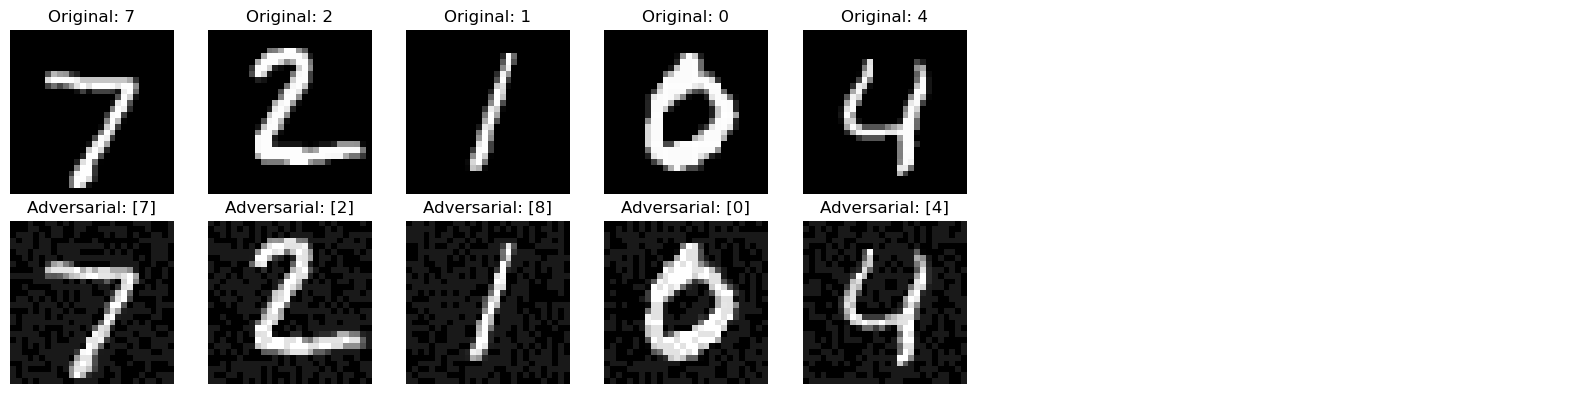

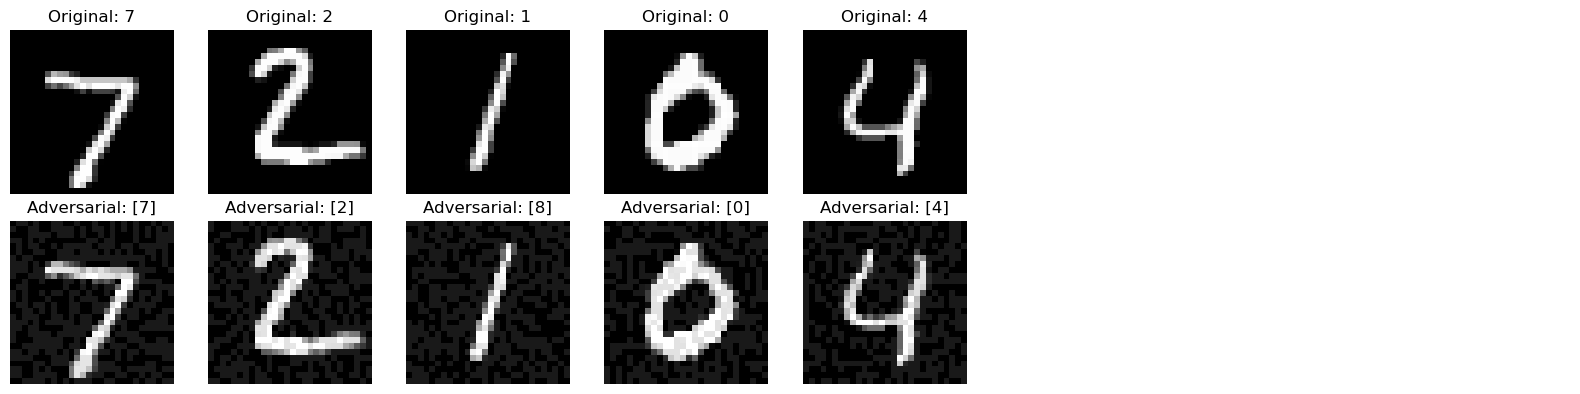

In [18]:
## Visualize 함수


visualize_comparison(fgsm_original_images,fgsm_perturbed_images,fgsm_origial_labels,fgsm_perturbed_labels, num_images=5)

visualize_comparison(pgd_original_images,pgd_perturbed_images,pgd_origial_labels,pgd_perturbed_labels, num_images=5)

C:\Users\user\AppData\Local\Temp\ipykernel_2388\688231516.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', 10)  # Using a colormap with 10 colors


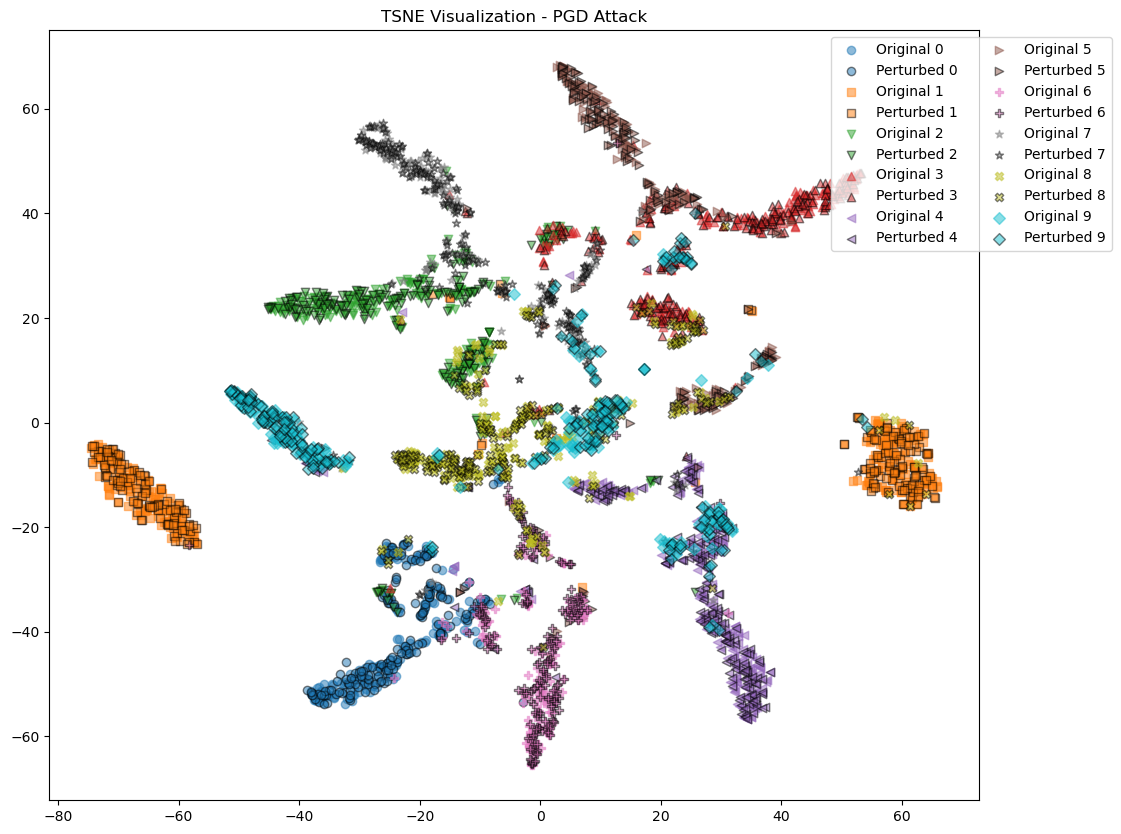

In [19]:
# FGSM 기반 시각화
tsne_features, labels = visualize_tsne(
    model=model, 
    test_loader=test_loader, 
    epsilon=epsilon, 
    alpha=alpha, 
    iterations=iterations, 
    visualize=True, 
    num_images=2000, 
    mode='PGD'
)